## Cell 1 – Setup Awal & Import


Tujuan: Inisialisasi proyek, import semua library, dan definisi konfigurasi global.

In [1]:
import os
import json
import math
from datetime import datetime

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import auc as calc_auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)

# --- Konfigurasi global ---
DATA_PATH = "../data/telemetry_data.csv"
MODEL_DIR = "../models"
NOTEBOOK_OUTPUT = "train_model_adaptive.ipynb"
MODEL_IF_PATH = os.path.join(MODEL_DIR, "isolation_forest.joblib")
MODEL_LOF_PATH = os.path.join(MODEL_DIR, "lof_novelty.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "data_scaler.joblib")
FEATURES_PATH = "../data/feature_names.json"
METADATA_PATH = os.path.join(MODEL_DIR, "model_metadata.json")

RANDOM_STATE = 42
TEST_SIZE = 0.2 # 20% dari data NORMAL akan dipakai di set test
MIN_SAMPLES_REQUIRED = 100 # Minimal data normal untuk training

## Cell 2 – Deteksi Fitur & Validasi Dataset


Tujuan: Mengecek fitur yang tersedia di CSV dan menyiapkan tabel visualisasi.

In [2]:
DESIRED_FEATURES = [
    "altitude", "gps_alt",
    "ground_speed", "airspeed", "vertical_speed",
    "heading", "pitch", "roll", "yaw",
    "accel_x", "accel_y", "accel_z",
    "gyro_x", "gyro_y", "gyro_z",
    "battery_level", "battery_voltage", "battery_current", "temperature_battery",
    "motor_rpm_1", "motor_rpm_2", "motor_rpm_3", "motor_rpm_4",
    "motor_temp_1", "motor_temp_2", "motor_temp_3", "motor_temp_4",
    "throttle_position", "payload_weight", "lidar_altitude", "obstacle_distance",
    "sat_count", "gps_fix_type", "link_quality", "signal_strength",
    "mode", "system_status"
]

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {DATA_PATH}")

df_header = pd.read_csv(DATA_PATH, nrows=2)
available_features = [f for f in DESIRED_FEATURES if f in df_header.columns]

if len(available_features) == 0:
    raise ValueError("Tidak ada fitur yang cocok ditemukan di CSV.")

print(f"Detected {len(available_features)} available features.")

# Buat DataFrame dengan status tersedia/tidak
df_features = pd.DataFrame({
    'Feature': DESIRED_FEATURES,
    'Available': ['Yes' if f in available_features else 'No' for f in DESIRED_FEATURES]
})

# Fungsi untuk membagi DataFrame menjadi beberapa kolom
def split_dataframe(df, n_cols=4):
    n_rows = math.ceil(len(df) / n_cols)
    split_data = {}
    for i in range(n_cols):
        start = i * n_rows
        end = start + n_rows
        col_values = df['Feature'][start:end].reset_index(drop=True) + ' (' + df['Available'][start:end].reset_index(drop=True) + ')'
        split_data[f'Column {i+1}'] = col_values
    return pd.DataFrame(split_data)

df_split = split_dataframe(df_features, n_cols=4)

# Tampilkan tabel multi kolom tanpa warning
display(df_split.style.map(
    lambda val: 'color: green;' if 'Yes' in str(val) else 'color: red;'
))

Detected 37 available features.


,Column 1,Column 2,Column 3,Column 4
0,altitude (Yes),accel_y (Yes),motor_rpm_2 (Yes),obstacle_distance (Yes)
1,gps_alt (Yes),accel_z (Yes),motor_rpm_3 (Yes),sat_count (Yes)
2,ground_speed (Yes),gyro_x (Yes),motor_rpm_4 (Yes),gps_fix_type (Yes)
3,airspeed (Yes),gyro_y (Yes),motor_temp_1 (Yes),link_quality (Yes)
4,vertical_speed (Yes),gyro_z (Yes),motor_temp_2 (Yes),signal_strength (Yes)
5,heading (Yes),battery_level (Yes),motor_temp_3 (Yes),mode (Yes)
6,pitch (Yes),battery_voltage (Yes),motor_temp_4 (Yes),system_status (Yes)
7,roll (Yes),battery_current (Yes),throttle_position (Yes),nan
8,yaw (Yes),temperature_battery (Yes),payload_weight (Yes),nan
9,accel_x (Yes),motor_rpm_1 (Yes),lidar_altitude (Yes),nan


## Cell 3 – Load dan Preprocessing Data

Tujuan: Memuat data, membersihkan NaN, duplikat, dan memilih fitur numerik.

In [3]:
df = pd.read_csv(DATA_PATH)

# Cek kolom event
if 'event' not in df.columns:
    raise ValueError("Kolom 'event' tidak ditemukan. Kolom ini Wajib ada untuk membuat label.")

# 1. Buat Label (y_true)
# Asumsi: event kosong = Normal (0), event isi = Anomali (1)
y_true = (df['event'].fillna('') != '').astype(int)

# 2. Siapkan Fitur (X)
X = df[available_features].copy()

# 3. Cleaning X (seperti kode asli)
X = X.replace([np.inf, -np.inf], np.nan)
# Simpan index sebelum dropna
original_index = X.index
X = X.dropna(how='all')
# Filter y_true agar sesuai dengan X setelah dropna
y_true = y_true.loc[X.index]

for col in X.columns:
    if X[col].dtype in [np.float64, np.int64]:
        X[col] = X[col].fillna(X[col].median())
    else:
        # Hati-hati, jika mode() kosong
        if not X[col].mode().empty:
            X[col] = X[col].fillna(X[col].mode().iloc[0])
        else:
            X[col] = X[col].fillna(X[col].dtype.type()) # Fill dengan default type (0 atau "")

# Simpan index sebelum drop_duplicates
original_index = X.index
X = X.drop_duplicates()
# Filter y_true agar sesuai dengan X setelah drop_duplicates
y_true = y_true.loc[X.index].reset_index(drop=True)
X = X.reset_index(drop=True)


print(f"Loaded data: {X.shape[0]} rows, {X.shape[1]} columns")
print(f"Total anomalies in source file: {y_true.sum()} ({y_true.mean()*100:.2f}%)")

# --- (BARU) FEATURE ENGINEERING DIMULAI ---
print("\n🛠️  Starting Feature Engineering...")

# 1. Agregat Motor (Mendeteksi ketidakseimbangan)
# axis=1 menghitung std dev *antar* 4 motor di baris yang sama
motor_rpm_cols = ['motor_rpm_1', 'motor_rpm_2', 'motor_rpm_3', 'motor_rpm_4']
if all(c in X.columns for c in motor_rpm_cols):
    X['motor_rpm_std'] = X[motor_rpm_cols].std(axis=1)
    X['motor_rpm_mean'] = X[motor_rpm_cols].mean(axis=1)
    print(" + Created motor RPM features (std, mean)")

motor_temp_cols = ['motor_temp_1', 'motor_temp_2', 'motor_temp_3', 'motor_temp_4']
if all(c in X.columns for c in motor_temp_cols):
    X['motor_temp_std'] = X[motor_temp_cols].std(axis=1)
    print(" + Created motor Temp features (std)")

# 2. Sensor Disagreement (Mendeteksi sensor glitch)
alt_cols = ['altitude', 'gps_alt', 'lidar_altitude']
if all(c in X.columns for c in alt_cols):
    X['alt_disagreement_std'] = X[alt_cols].std(axis=1)
    print(" + Created altitude disagreement (std)")

# 3. Power System
if 'battery_voltage' in X.columns and 'battery_current' in X.columns:
    X['power_draw'] = X['battery_voltage'] * X['battery_current']
    print(" + Created power draw feature")

# 4. Rolling Statistics (Mendeteksi getaran atau spike)
# Menggunakan window 5 data points
if 'accel_z' in X.columns:
    X['roll_accel_z_std'] = X['accel_z'].rolling(window=5, min_periods=1).std()
    print(" + Created rolling accel_z std (vibration)")

if 'gyro_x' in X.columns:
    X['roll_gyro_x_std'] = X['gyro_x'].rolling(window=5, min_periods=1).std()
    print(" + Created rolling gyro_x std (instability)")

# Isi NaN yang muncul dari rolling std (di awal data)
# dan dari std() jika semua input NaN
X = X.fillna(0)

print("✅ Feature Engineering complete.")
# --- (BARU) FEATURE ENGINEERING SELESAI ---


# 4. Ambil fitur numerik SETELAH membuat fitur baru
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_features].copy()

if len(X.columns) < 10: # Dinaikkan dari 5
    raise ValueError(f"Fitur numerik terlalu sedikit untuk dilatih ({len(X.columns)}).")

print(f"✅ Total numeric features after engineering: {len(X.columns)}")

Loaded data: 17970 rows, 37 columns
Total anomalies in source file: 3597 (20.02%)

🛠️  Starting Feature Engineering...
 + Created motor RPM features (std, mean)
 + Created motor Temp features (std)
 + Created altitude disagreement (std)
 + Created power draw feature
 + Created rolling accel_z std (vibration)
 + Created rolling gyro_x std (instability)
✅ Feature Engineering complete.
✅ Total numeric features after engineering: 42


## Cell 4 – Fungsi Sisipkan Anomali dan Evaluasi

Tujuan: Menyisipkan anomali sintetis dan mengevaluasi label model.

In [4]:
# Kita tidak lagi inject anomali. Kita split berdasarkan 'event'.

SEED = RANDOM_STATE

# 1. Pisahkan data Normal dan Anomali berdasarkan y_true dari file
X_norm_all = X[y_true == 0]
X_anom_all = X[y_true == 1]

print(f"Data Normal: {len(X_norm_all)} rows")
print(f"Data Anomali: {len(X_anom_all)} rows")

if len(X_norm_all) < MIN_SAMPLES_REQUIRED:
     raise ValueError(f"Data normal terlalu sedikit ({len(X_norm_all)}) untuk training.")
if len(X_anom_all) == 0:
    print("PERINGATAN: Tidak ada data anomali di file. Evaluasi mungkin tidak akurat.")

# 2. Split data NORMAL untuk train dan test
# Model *hanya* boleh train pada data normal (unsupervised)
X_norm_train, X_norm_test = train_test_split(
    X_norm_all,
    test_size=TEST_SIZE,
    random_state=SEED
)

# 3. Buat set training (HANYA NORMAL)
X_train = X_norm_train.reset_index(drop=True)

# 4. Buat set testing (Campuran Normal + Anomali)
X_test = pd.concat(
    [X_norm_test.reset_index(drop=True), X_anom_all.reset_index(drop=True)],
    ignore_index=True
)

# 5. Buat label untuk testing
y_test = np.concatenate([
    np.zeros(len(X_norm_test), dtype=int),  # Label 0 untuk data normal
    np.ones(len(X_anom_all), dtype=int)   # Label 1 untuk data anomali
])

print(f"\nTraining set: {len(X_train)} rows (100% Normal)")
print(f"Test set: {len(X_test)} rows")

unique, counts = np.unique(y_test, return_counts=True)
print("Class distribution in test set:")
for label, count in zip(unique, counts):
    cls = "Normal" if label == 0 else "Anomaly"
    print(f"  {cls}: {count} samples ({count/len(y_test)*100:.2f}%)")

# Hitung rasio anomali aktual
DATA_ANOMALY_FRAC = y_true.mean()

Data Normal: 14373 rows
Data Anomali: 3597 rows

Training set: 11498 rows (100% Normal)
Test set: 6472 rows
Class distribution in test set:
  Normal: 2875 samples (44.42%)
  Anomaly: 3597 samples (55.58%)


## Cell 5 – Scaling Data

Tujuan: Menyiapkan data skala untuk model.

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to {SCALER_PATH}")

Scaler saved to ../models\data_scaler.joblib


# Cell 6 – Training dan Optimasi IsolationForest

Tujuan: Mencari hyperparameter terbaik IsolationForest.

In [6]:
best_if = None
best_auc = -np.inf
# Kita perlu contamination factor yang sesuai dengan data test
test_anomaly_frac = y_test.mean()
print(f"Using contamination factor around {test_anomaly_frac:.3f} for IF tuning")

for cont in [max(0.01, test_anomaly_frac - 0.01), test_anomaly_frac, test_anomaly_frac + 0.01]:
    cont = max(0.001, min(0.49, cont)) # Batasi contamination
    for n_est in [100, 200]:
        clf = IsolationForest(n_estimators=n_est, contamination=cont, random_state=RANDOM_STATE, n_jobs=-1)
        clf.fit(X_train_scaled)
        auc = roc_auc_score(y_test, -clf.decision_function(X_test_scaled))
        if auc > best_auc:
            best_auc = auc
            best_if = clf

joblib.dump(best_if, MODEL_IF_PATH)
print(f"Best IsolationForest saved to {MODEL_IF_PATH}, AUC={best_auc:.4f}")
print(f"Best IF params: {best_if.get_params()}")

Using contamination factor around 0.556 for IF tuning
Best IsolationForest saved to ../models\isolation_forest.joblib, AUC=0.6503
Best IF params: {'bootstrap': False, 'contamination': 0.49, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Cell 7 – Training LOF

Tujuan: Latih LOF novelty.

In [7]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination='auto')
lof.fit(X_train_scaled)
joblib.dump(lof, MODEL_LOF_PATH)
print(f"LOF saved to {MODEL_LOF_PATH}")

LOF saved to ../models\lof_novelty.joblib


## Cell 8 – Fungsi Evaluasi Skor Anomali

Tujuan: Konversi skor decision_function menjadi skor anomali dan evaluasi.

In [8]:
# Konversi decision_function -> anomaly_score (semakin besar = lebih anomali)
def to_anomaly_score(scores, y_true=None):
    a_score = -scores
    if y_true is not None:
        try:
            a_auc = roc_auc_score(y_true, a_score)
            if a_auc < 0.5:
                a_score = -a_score
        except Exception:
            pass
    return a_score

# Versi evaluasi yang pakai skor anomali
def evaluate_with_best_threshold_from_anom(y_true, anom_score):
    prec, rec, thr = precision_recall_curve(y_true, anom_score)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    idx = np.nanargmax(f1)
    y_pred = (anom_score >= thr[idx]).astype(int)
    return {
        "threshold": float(thr[idx]),
        "roc_auc": float(roc_auc_score(y_true, anom_score)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1[idx]),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }

## Cell 9 – Evaluasi dengan Threshold Adaptif

Tujuan: Hitung skor anomali, pilih threshold terbaik, dan prediksi y_pred.

In [9]:
def evaluate_with_best_threshold(y_true, scores):
    anom_score = np.array(scores)
    # Pastikan arah benar: skor tinggi = anomali
    
    # Cek jika y_true punya kedua kelas
    if len(np.unique(y_true)) < 2:
        print("Peringatan: y_true hanya punya satu kelas. Arah skor tidak bisa divalidasi.")
    elif np.mean(anom_score[y_true == 1]) < np.mean(anom_score[y_true == 0]):
        anom_score = -anom_score

    prec, rec, thr = precision_recall_curve(y_true, anom_score)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)

    # Tangani kasus nilai threshold tidak stabil (semua skor sama)
    if np.allclose(anom_score.max(), anom_score.min()):
        best_t = np.median(anom_score)
    else:
        # Ambil F1 non-NaN terbesar
        valid_f1 = f1[~np.isnan(f1)]
        if len(valid_f1) == 0:
            best_t = np.median(thr)
        else:
            best_t_index = np.nanargmax(f1)
            best_t = thr[best_t_index]

    y_pred = (anom_score >= best_t).astype(int)

    return {
        "threshold": float(best_t),
        "roc_auc": float(roc_auc_score(y_true, anom_score)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }

# --- Skor asli dari model ---
iso_scores = best_if.decision_function(X_test_scaled)
lof_scores = lof.decision_function(X_test_scaled)

# --- Evaluasi model individual ---
iso_metrics = evaluate_with_best_threshold(y_test, iso_scores)
lof_metrics = evaluate_with_best_threshold(y_test, lof_scores)

# --- Normalisasi global pakai Z-score ---
scaler_ens = StandardScaler()
combined = np.vstack([iso_scores, lof_scores]).T
combined_std = scaler_ens.fit_transform(combined)

iso_std = combined_std[:, 0]
lof_std = combined_std[:, 1]

# --- Ensemble dengan bobot adaptif ---
# Bobot ditentukan berdasarkan ROC AUC masing-masing model
auc_sum = iso_metrics["roc_auc"] + lof_metrics["roc_auc"]
if auc_sum == 0:
    w_if, w_lof = 0.5, 0.5 # Fallback
else:
    w_if = iso_metrics["roc_auc"] / auc_sum
    w_lof = lof_metrics["roc_auc"] / auc_sum

ensemble_raw = -(w_if * iso_std + w_lof * lof_std) # Arah dibalik: tinggi = anomali

# --- Normalisasi dinamis biar threshold bekerja baik ---
p1 = np.percentile(ensemble_raw, 1)
p99 = np.percentile(ensemble_raw, 99)
if p99 == p1:
    ensemble_scores = np.zeros_like(ensemble_raw) # Fallback jika semua skor sama
else:
    ensemble_scores = (ensemble_raw - p1) / (p99 - p1)
    
ensemble_scores = np.clip(ensemble_scores, 0, 1)

# --- Evaluasi ---
ens_metrics = evaluate_with_best_threshold(y_test, ensemble_scores)

print("IsolationForest:", iso_metrics)
print("LOF:", lof_metrics)
print("Ensemble:", ens_metrics)

IsolationForest: {'threshold': -0.03029942260369789, 'roc_auc': 0.6503060763196383, 'precision': 0.5764647467725919, 'recall': 0.9683069224353628, 'f1': 0.7226890756302521, 'confusion_matrix': [[316, 2559], [114, 3483]]}
LOF: {'threshold': -0.44739952193879695, 'roc_auc': 0.8873260083886331, 'precision': 0.84860088365243, 'recall': 0.8009452321378927, 'f1': 0.8240846681922197, 'confusion_matrix': [[2361, 514], [716, 2881]]}
Ensemble: {'threshold': 0.08413281192509961, 'roc_auc': 0.70941639772274, 'precision': 0.6076369673491976, 'recall': 0.9157631359466222, 'f1': 0.7305389221556886, 'confusion_matrix': [[748, 2127], [303, 3294]]}


## Cell 10 – Simpan Metadata dan Artifak Evaluasi

Tujuan: Simpan informasi fitur, model, dan skor evaluasi.

In [10]:
metadata = {
    'date_trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_samples_total': int(len(X)),
    'n_features_used': len(X.columns),
    'used_features': X.columns.tolist(),
    'data_anomaly_frac': float(DATA_ANOMALY_FRAC), # Menggunakan rasio dari data
    'isolationforest_optimized_metrics': iso_metrics,
    'lof_optimized_metrics': lof_metrics,
    'ensemble_optimized_metrics': ens_metrics
}

with open(FEATURES_PATH, 'w') as f:
    json.dump(X.columns.tolist(), f, indent=2)
with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=2)

joblib.dump({
    'y_test': y_test,
    'iso_scores': iso_scores,
    'lof_scores': lof_scores,
    'ensemble_scores': ensemble_scores
}, os.path.join(MODEL_DIR, 'eval_artifacts.joblib'))

print("✅ Metadata and evaluation artifacts saved.")

✅ Metadata and evaluation artifacts saved.


## Cell 11 – Ringkasan 

Tujuan: Menyeragamkan arah skor (tinggi = anomali) dan buat prediksi y_pred untuk setiap model.

In [11]:
print("\n=== MODEL TRAINING SUMMARY ===")
print(f"Tanggal training        : {metadata['date_trained']}")
print(f"Jumlah sampel total     : {metadata['n_samples_total']}")
print(f"Fitur digunakan         : {metadata['n_features_used']}")
print(f"Rasio anomali dari data  : {metadata['data_anomaly_frac']*100:.2f}%")

print("\n--- Performance ---")
print(f"IsolationForest F1: {iso_metrics['f1']:.4f} (AUC: {iso_metrics['roc_auc']:.4f})")
print(f"LOF F1: {lof_metrics['f1']:.4f} (AUC: {lof_metrics['roc_auc']:.4f})")
print(f"Ensemble F1: {ens_metrics['f1']:.4f} (AUC: {ens_metrics['roc_auc']:.4f})")

print(f"\nArtifacts tersimpan di: {MODEL_DIR}")


=== MODEL TRAINING SUMMARY ===
Tanggal training        : 2025-11-11 16:13:52
Jumlah sampel total     : 17970
Fitur digunakan         : 42
Rasio anomali dari data  : 20.02%

--- Performance ---
IsolationForest F1: 0.7227 (AUC: 0.6503)
LOF F1: 0.8241 (AUC: 0.8873)
Ensemble F1: 0.7305 (AUC: 0.7094)

Artifacts tersimpan di: ../models


## Cell 12 – Visualisasi

Semua skor diseragamkan: tinggi = anomali.
iso_pred dibuat menggunakan threshold dari iso_metrics.
lof_pred dibuat menggunakan threshold dari lof_metrics.
y_pred_best dibuat menggunakan threshold dari ens_metrics.

BAGIAN 1: RINGKASAN METRIK SEMUA MODEL


Model,ROC AUC,Precision,Recall,F1 Score
IsolationForest,0.6503,0.6980,0.3636,0.4782
LOF,0.8873,1.0000,0.2257,0.3683
Ensemble,0.7094,0.6076,0.9158,0.7305



BAGIAN 2: KURVA PR & ROC


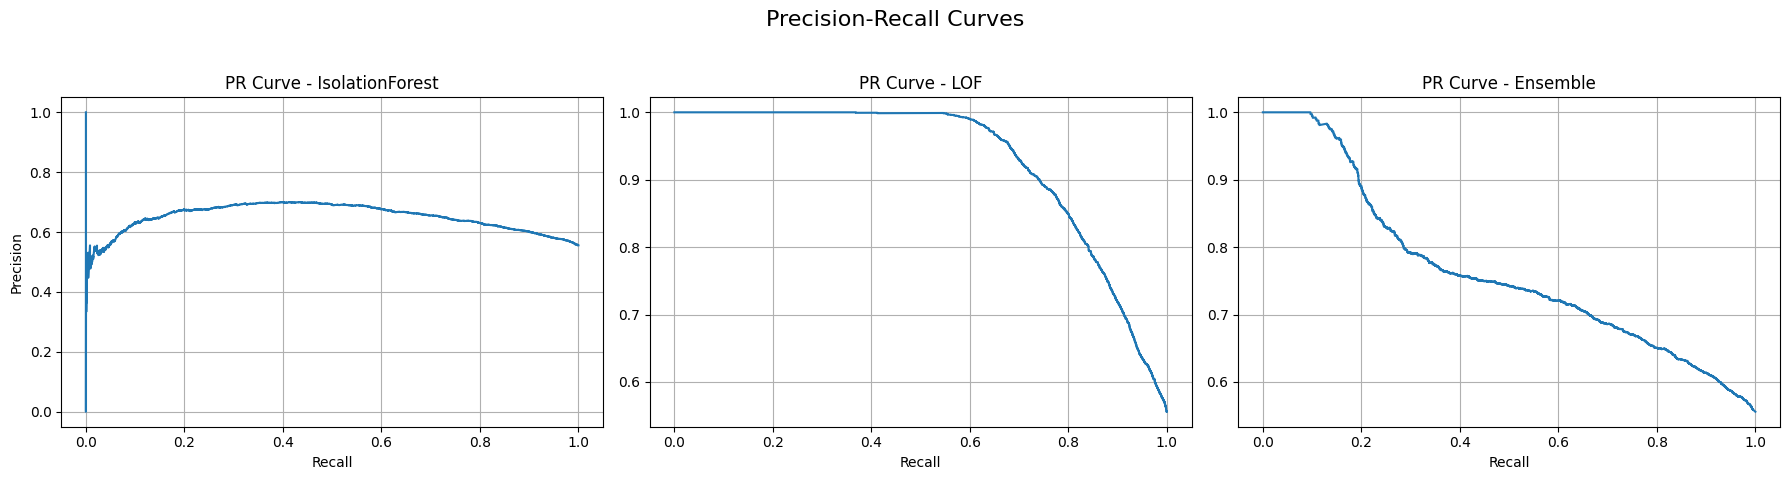

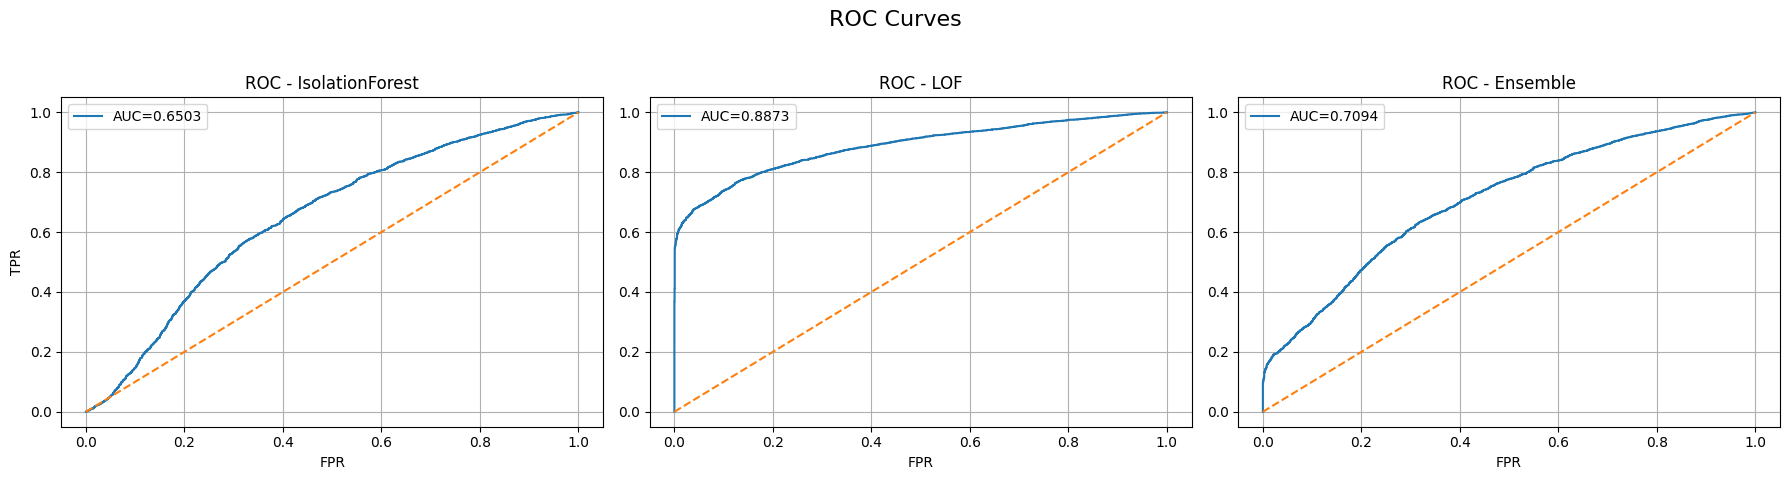

In [12]:
# --- Koreksi arah skor agar konsisten (skor tinggi = anomali) ---
iso_adj_scores = -iso_scores
lof_adj_scores = -lof_scores
ens_adj_scores = ensemble_scores

print("Semua skor diseragamkan: tinggi = anomali.")

# --- 0. Setup Awal & Pengecekan Variabel ---
# A. Isolation Forest
if 'iso_metrics' in globals() and 'threshold' in iso_metrics:
    # iso_metrics threshold dihitung dari iso_scores (tinggi=normal)
    # jadi kita pakai -iso_adj_scores
    iso_pred = (iso_adj_scores >= -iso_metrics['threshold']).astype(int)
    print("iso_pred dibuat menggunakan threshold dari iso_metrics.")
else:
    print("PERINGATAN: iso_metrics['threshold'] tidak ditemukan. iso_pred tidak akan akurat.")
    iso_pred = (iso_adj_scores >= 0.15).astype(int) # Fallback

# B. LOF
if 'lof_metrics' in globals() and 'threshold' in lof_metrics:
    lof_pred = (lof_adj_scores >= -lof_metrics['threshold']).astype(int)
    print("lof_pred dibuat menggunakan threshold dari lof_metrics.")
else:
    print("PERINGATAN: lof_metrics['threshold'] tidak ditemukan. lof_pred tidak akan akurat.")
    lof_pred = (lof_adj_scores >= 0).astype(int) # Fallback

# C. Ensemble
if 'ens_metrics' in globals() and 'threshold' in ens_metrics:
    # ens_metrics threshold dihitung dari ensemble_scores (tinggi=anomali)
    y_pred_best = (ens_adj_scores >= ens_metrics['threshold']).astype(int)
    print("y_pred_best dibuat menggunakan threshold dari ens_metrics.")
else:
    print("PERINGATAN: ens_metrics tidak ditemukan. Menggunakan threshold 0.5 default untuk y_pred_best.")
    y_pred_best = (ens_adj_scores >= 0.5).astype(int)


# --- 1. Ringkasan Metrik Semua Model ---
print("\n" + "="*60)
print("BAGIAN 1: RINGKASAN METRIK SEMUA MODEL")
print("="*60)

# Perhitungan AUC
fpr_i, tpr_i, _ = roc_curve(y_test, iso_adj_scores)
fpr_l, tpr_l, _ = roc_curve(y_test, lof_adj_scores)
fpr_e, tpr_e, _ = roc_curve(y_test, ens_adj_scores)
auc_i = calc_auc(fpr_i, tpr_i)
auc_l = calc_auc(fpr_l, tpr_l)
auc_e = calc_auc(fpr_e, tpr_e)

try:
    summary_df = pd.DataFrame({
        'Model': ['IsolationForest', 'LOF', 'Ensemble'],
        'ROC AUC': [auc_i, auc_l, auc_e],
        'Precision': [
            precision_score(y_test, iso_pred, zero_division=0),
            precision_score(y_test, lof_pred, zero_division=0),
            precision_score(y_test, y_pred_best, zero_division=0)
        ],
        'Recall': [
            recall_score(y_test, iso_pred),
            recall_score(y_test, lof_pred),
            recall_score(y_test, y_pred_best)
        ],
        'F1 Score': [
            f1_score(y_test, iso_pred, zero_division=0),
            f1_score(y_test, lof_pred, zero_division=0),
            f1_score(y_test, y_pred_best, zero_division=0)
        ]
    })

    display(summary_df.style.format({
        "ROC AUC": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1 Score": "{:.4f}"
    }).hide(axis="index"))

except Exception as e:
    print(f"Gagal membuat tabel ringkasan. Error: {e}")


# --- 2. Perhitungan Kurva PR ---
prec_i, rec_i, _ = precision_recall_curve(y_test, iso_adj_scores)
prec_l, rec_l, _ = precision_recall_curve(y_test, lof_adj_scores)
prec_e, rec_e, _ = precision_recall_curve(y_test, ens_adj_scores)


# --- 3. Plot PR dan ROC Curves (Subplots) ---
print("\n" + "="*60)
print("BAGIAN 2: KURVA PR & ROC")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Precision-Recall Curves', fontsize=16)
axes[0].plot(rec_i, prec_i); axes[0].set_title('PR Curve - IsolationForest'); axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision'); axes[0].grid(True)
axes[1].plot(rec_l, prec_l); axes[1].set_title('PR Curve - LOF'); axes[1].set_xlabel('Recall'); axes[1].grid(True)
axes[2].plot(rec_e, prec_e); axes[2].set_title('PR Curve - Ensemble'); axes[2].set_xlabel('Recall'); axes[2].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ROC Curves', fontsize=16)
axes[0].plot(fpr_i, tpr_i, label=f'AUC={auc_i:.4f}'); axes[0].plot([0, 1], [0, 1], linestyle='--'); axes[0].set_title('ROC - IsolationForest'); axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR'); axes[0].legend(); axes[0].grid(True)
axes[1].plot(fpr_l, tpr_l, label=f'AUC={auc_l:.4f}'); axes[1].plot([0, 1], [0, 1], linestyle='--'); axes[1].set_title('ROC - LOF'); axes[1].set_xlabel('FPR'); axes[1].legend(); axes[1].grid(True)
axes[2].plot(fpr_e, tpr_e, label=f'AUC={auc_e:.4f}'); axes[2].plot([0, 1], [0, 1], linestyle='--'); axes[2].set_title('ROC - Ensemble'); axes[2].set_xlabel('FPR'); axes[2].legend(); axes[2].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


BAGIAN 3: DISTRIBUSI SKOR (TOTAL)


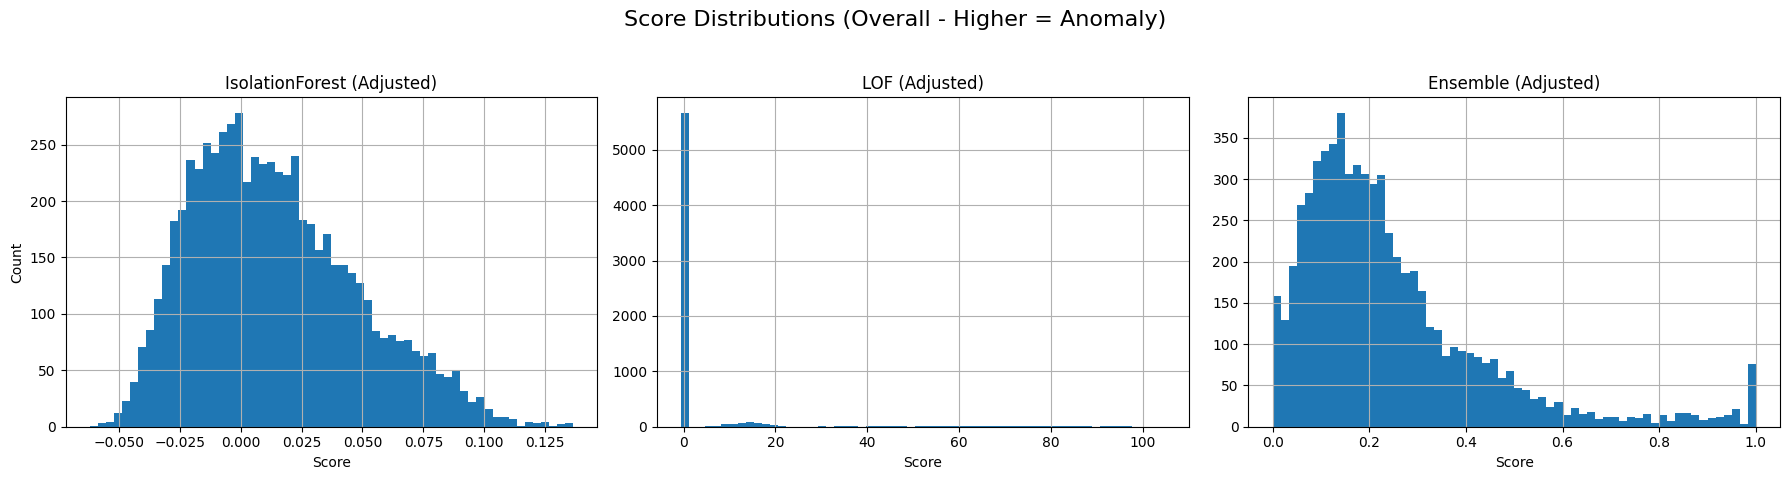


BAGIAN 4: CONFUSION MATRIX & PROYEKSI PCA


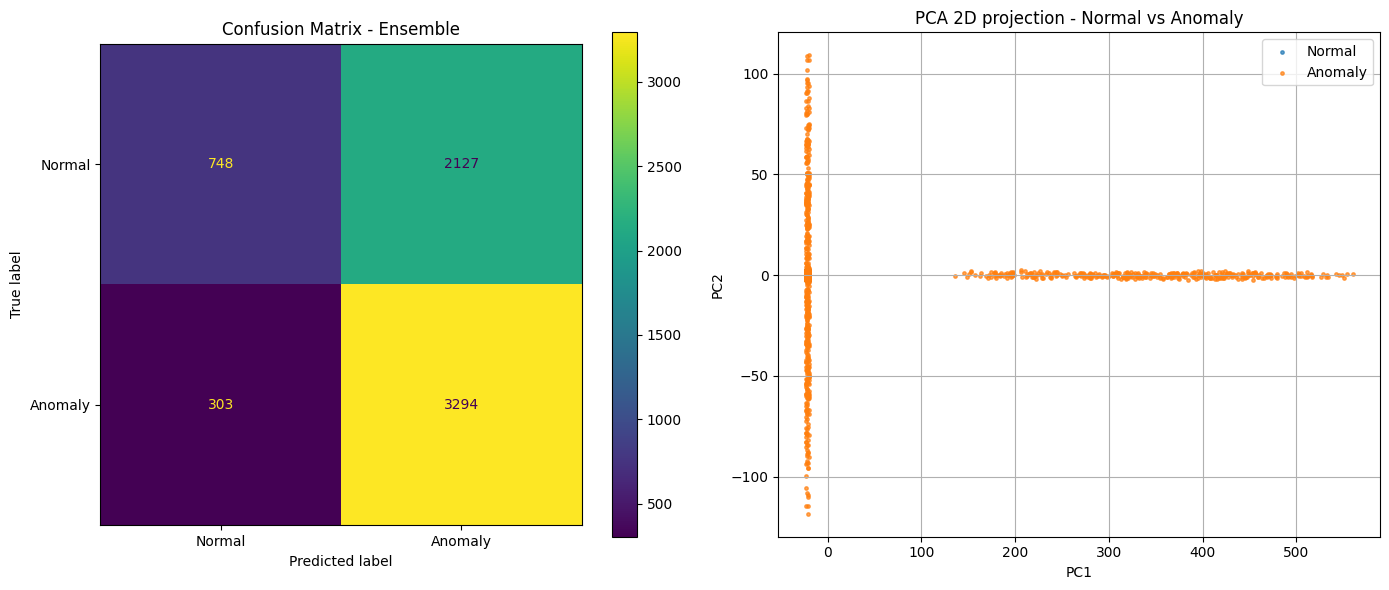


BAGIAN 5: STATISTIK & DISTRIBUSI SKOR (PER KELAS)

Statistik Skor Normal (N=2875):
  Min/Mean/Std/Max: 0.0000 / 0.1677 / 0.1160 / 0.6214

Statistik Skor Anomali (N=3597):
  Min/Mean/Std/Max: 0.0000 / 0.3046 / 0.2222 / 1.0000


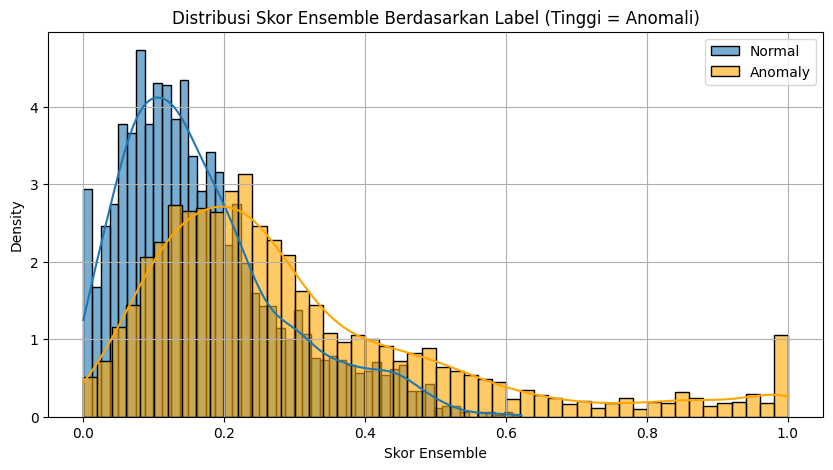

In [13]:
# --- 4. Distribusi Skor Total (Histogram) ---
print("\n" + "="*60)
print("BAGIAN 3: DISTRIBUSI SKOR (TOTAL)")
print("="*60)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Score Distributions (Overall - Higher = Anomaly)', fontsize=16)
# Skor yang sudah disesuaikan (tinggi = anomali)
axes[0].hist(iso_adj_scores, bins=60); axes[0].set_title('IsolationForest (Adjusted)'); axes[0].set_xlabel('Score'); axes[0].set_ylabel('Count'); axes[0].grid(True)
axes[1].hist(lof_adj_scores, bins=60); axes[1].set_title('LOF (Adjusted)'); axes[1].set_xlabel('Score'); axes[1].grid(True)
axes[2].hist(ens_adj_scores, bins=60); axes[2].set_title('Ensemble (Adjusted)'); axes[2].set_xlabel('Score'); axes[2].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# --- 5. Confusion Matrix dan Proyeksi PCA ---
print("\n" + "="*60)
print("BAGIAN 4: CONFUSION MATRIX & PROYEKSI PCA")
print("="*60)
# Persiapan untuk PCA
# X_test adalah dataframe unscaled dari Cell 4
if 'X_test' in globals():
    try:
        pca = PCA(n_components=2)
        # Gunakan X_test_scaled yang sudah dibuat di Cell 5
        proj = pca.fit_transform(X_test_scaled)
        pca_ready = True
    except Exception as e:
        print(f"Gagal menjalankan PCA: {e}"); pca_ready = False
else:
    pca_ready = False

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# 5A. Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(values_format='d', cmap='viridis', ax=axes[0]); axes[0].set_title('Confusion Matrix - Ensemble')
# 5B. PCA 2D projection
if pca_ready:
    axes[1].scatter(proj[y_test == 0, 0], proj[y_test == 0, 1], s=6, label='Normal', alpha=0.7)
    axes[1].scatter(proj[y_test == 1, 0], proj[y_test == 1, 1], s=6, label='Anomaly', alpha=0.7)
    axes[1].set_title('PCA 2D projection - Normal vs Anomaly'); axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2'); axes[1].legend(); axes[1].grid(True)
else:
    axes[1].text(0.5, 0.5, 'PCA plot tidak tersedia', ha='center', va='center'); axes[1].set_title('PCA 2D projection')
plt.tight_layout(); plt.show()


# --- 6. Detail Statistik & Distribusi Skor per Kelas ---
print("\n" + "="*60)
print("BAGIAN 5: STATISTIK & DISTRIBUSI SKOR (PER KELAS)")
print("="*60)
scores_norm = ens_adj_scores[y_test == 0]
scores_anom = ens_adj_scores[y_test == 1]

if len(scores_norm) > 0:
    print(f"\nStatistik Skor Normal (N={len(scores_norm)}):"); print(f"  Min/Mean/Std/Max: {np.min(scores_norm):.4f} / {np.mean(scores_norm):.4f} / {np.std(scores_norm):.4f} / {np.max(scores_norm):.4f}")
else:
    print("\nTidak ada data Normal (y_test == 0) yang ditemukan.")
if len(scores_anom) > 0:
    print(f"\nStatistik Skor Anomali (N={len(scores_anom)}):"); print(f"  Min/Mean/Std/Max: {np.min(scores_anom):.4f} / {np.mean(scores_anom):.4f} / {np.std(scores_anom):.4f} / {np.max(scores_anom):.4f}")
else:
    print("\nTidak ada data Anomali (y_test == 1) yang ditemukan.")

# 6B. Distribusi Skor vs Label
plt.figure(figsize=(10,5))
sns.histplot(scores_norm, bins=50, alpha=0.6, label='Normal', kde=True, stat="density")
sns.histplot(scores_anom, bins=50, alpha=0.6, label='Anomaly', kde=True, stat="density", color='orange')
plt.title('Distribusi Skor Ensemble Berdasarkan Label (Tinggi = Anomali)')
plt.xlabel('Skor Ensemble'); plt.ylabel('Density'); plt.legend(); plt.grid(True); plt.show()


BAGIAN 6: ANALISIS KESALAHAN (FP/FN)
Membuat df_test untuk analisis...

Total False Positives: 2127
Total False Negatives: 303

Contoh False Positives (hingga 5 baris):


,altitude,gps_alt,ground_speed,airspeed,vertical_speed,heading,pitch,roll,yaw,accel_x,...,signal_strength,motor_rpm_std,motor_rpm_mean,motor_temp_std,alt_disagreement_std,power_draw,roll_accel_z_std,roll_gyro_x_std,y_true,y_pred
0,307.189122,305.250786,53.698327,52.850068,28.148124,89.977997,-1.977773,1.127198,89.977997,0.164459,...,-93.185618,1248.179955,5639.185283,10.791633,1.155620,330.440061,0.415066,0.015278,0,1
3,2672.263394,2672.027275,33.070538,32.624828,27.593370,139.359990,-3.559641,14.340193,139.359990,-0.047577,...,-94.162289,933.631346,5978.562122,19.346295,0.126163,103.277264,0.220981,0.009932,0,1
4,916.209216,915.046252,53.718214,55.355230,-32.994944,129.549901,-3.334616,4.437262,129.549901,0.378937,...,-98.538386,1267.247769,5631.257708,11.255729,0.840007,17.732166,0.216087,0.014737,0,1
5,4801.912572,4803.710225,15.674452,17.387962,-33.016747,358.942962,-2.591179,-7.570356,358.942962,0.092746,...,-84.984641,1188.416610,4825.414760,8.639102,1.153567,9.808845,0.265217,0.014503,0,1
6,0.000000,-1.111611,0.000000,0.000000,0.000000,45.167828,0.000000,0.000000,45.167828,0.416481,...,-58.845838,0.000000,0.000000,5.987957,0.791514,0.000000,0.300863,0.005292,0,1



Contoh False Negatives (hingga 5 baris):


,altitude,gps_alt,ground_speed,airspeed,vertical_speed,heading,pitch,roll,yaw,accel_x,...,signal_strength,motor_rpm_std,motor_rpm_mean,motor_temp_std,alt_disagreement_std,power_draw,roll_accel_z_std,roll_gyro_x_std,y_true,y_pred
2936,5000.038242,4999.526233,43.031168,42.790644,0.038242,143.863432,-2.563441,11.377819,143.863432,-0.356477,...,-67.974436,1093.605036,6957.441166,16.767655,0.277619,-3.097045,0.222689,0.007305,1,0
2937,4998.568737,5000.156697,61.897949,61.560889,-1.431263,151.717582,-2.249627,3.202329,151.717582,0.489390,...,-64.874388,1835.499432,6591.120768,12.249767,1.049036,12.093903,0.249554,0.007128,1,0
2940,4998.968035,4999.833982,29.894024,28.228072,-1.031965,151.018661,-2.557099,-10.106205,151.018661,-0.038335,...,-104.919566,1472.621935,4761.932927,19.397033,0.623250,6.108048,0.340444,0.010206,1,0
2945,5000.056420,4999.566630,41.892934,43.188230,0.056420,161.795141,-5.298290,-8.347818,161.795141,0.331584,...,-88.034947,1753.156469,5942.747475,14.921824,0.245271,-5.124395,0.176868,0.004370,1,0
2947,5000.035120,4998.191835,13.894171,13.268310,0.035120,160.712132,-3.539251,-12.150159,160.712132,-0.369624,...,-109.470804,466.330899,4366.181814,12.948997,1.105721,14.709428,0.323001,0.009769,1,0



Fitur dengan rata-rata tertinggi pada kesalahan prediksi (FP/FN):


motor_rpm_1       5152.658603
motor_rpm_3       5150.504446
motor_rpm_2       5143.731567
motor_rpm_mean    5141.374403
motor_rpm_4       5118.602995
altitude          3360.496307
gps_alt           3360.491538
lidar_altitude    3360.488555
motor_rpm_std     1273.627175
heading            110.105291
dtype: float64

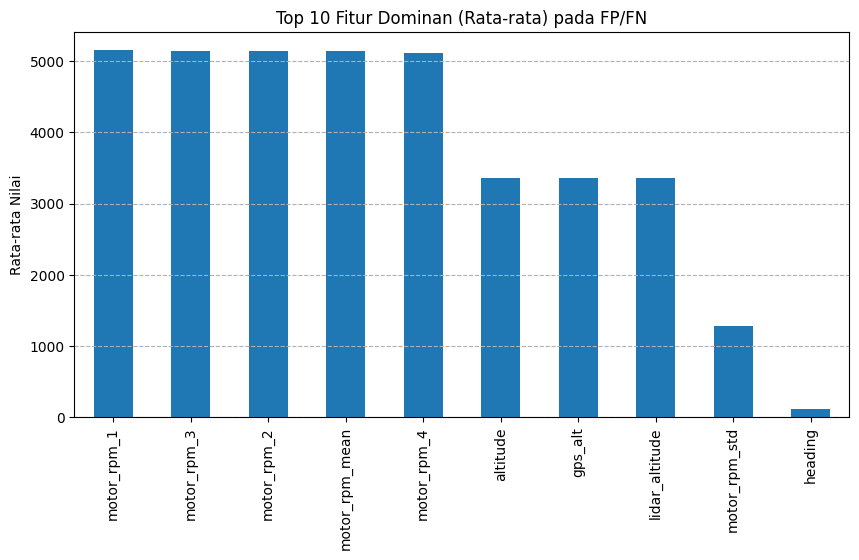


BAGIAN 7: KORELASI SKOR ANTAR MODEL

Korelasi antar skor model (skor tinggi = anomali):


,IsolationForest,LOF,Ensemble
IsolationForest,1.00,0.05,0.63
LOF,0.05,1.00,0.81
Ensemble,0.63,0.81,1.00


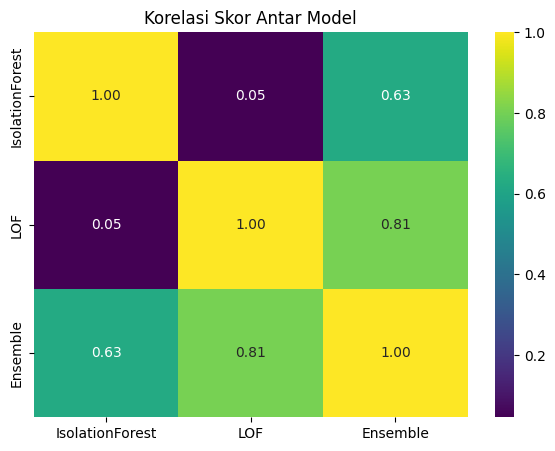


BAGIAN 8: STABILITAS THRESHOLD ENSEMBLE


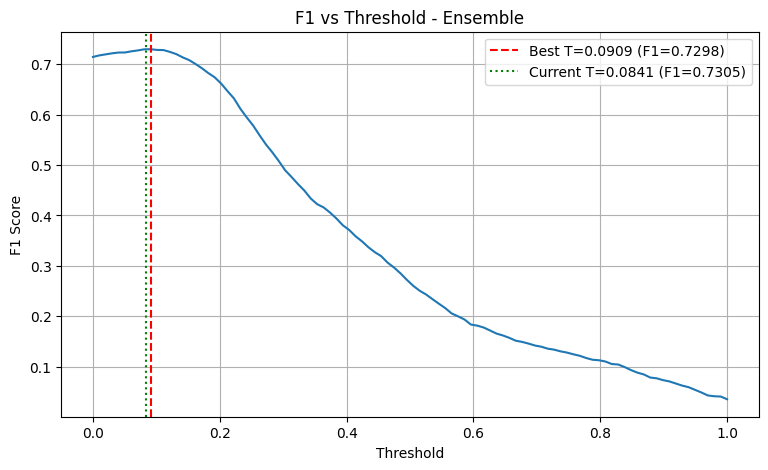

Threshold optimal (dari F1): 0.09091, F1 tertinggi: 0.7298
Threshold yang digunakan saat ini: 0.08413, F1: 0.7305

Analisis Selesai.


In [14]:
# --- 7. Analisis Kesalahan (False Positives & False Negatives) ---
print("\n" + "="*60)
print("BAGIAN 6: ANALISIS KESALAHAN (FP/FN)")
print("="*60)

# X_test adalah dataframe unscaled dari Cell 4
if 'X_test' in globals():
    print("Membuat df_test untuk analisis...")
    try:
        df_test = X_test.copy() # X_test adalah unscaled dataframe
        df_test['y_true'] = y_test
        df_test['y_pred'] = y_pred_best
        df_test_ready = True
    except Exception as e:
        print(f"Gagal membuat df_test: {e}"); df_test_ready = False
else:
    print("X_test tidak ditemukan, tidak dapat membuat df_test."); df_test_ready = False

if df_test_ready:
    false_pos = df_test[(df_test['y_true'] == 0) & (df_test['y_pred'] == 1)]
    false_neg = df_test[(df_test['y_true'] == 1) & (df_test['y_pred'] == 0)]
    print(f"\nTotal False Positives: {len(false_pos)}"); print(f"Total False Negatives: {len(false_neg)}")

    if len(false_pos) > 0:
        print("\nContoh False Positives (hingga 5 baris):"); display(false_pos.head(5))
    if len(false_neg) > 0:
        print("\nContoh False Negatives (hingga 5 baris):"); display(false_neg.head(5))

    # 7B. Evaluasi Fitur pada FP/FN
    if (len(false_pos) + len(false_neg)) > 0:
        combined_err = pd.concat([false_pos, false_neg])
        feature_cols = [col for col in combined_err.columns if col not in ['y_true', 'y_pred']]
        if len(feature_cols) > 0:
            feature_means = combined_err[feature_cols].mean().sort_values(ascending=False)
            print("\nFitur dengan rata-rata tertinggi pada kesalahan prediksi (FP/FN):")
            display(feature_means.head(10))

            plt.figure(figsize=(10, 5))
            feature_means.head(10).plot(kind='bar')
            plt.title("Top 10 Fitur Dominan (Rata-rata) pada FP/FN")
            plt.ylabel("Rata-rata Nilai")
            plt.grid(axis='y', linestyle='--')
            plt.show()
        else:
            print("\nTidak dapat menganalisis fitur: kolom fitur tidak ditemukan di df_test.")
    else:
        print("\nTidak ada kesalahan (FP/FN), analisis fitur tidak diperlukan.")
else:
    print("\nTidak dapat menampilkan contoh FP/FN karena df_test tidak tersedia.")


# --- 8. Evaluasi Stabilitas Model (Korelasi Skor) ---
print("\n" + "="*60)
print("BAGIAN 7: KORELASI SKOR ANTAR MODEL")
print("="*60)
try:
    score_df = pd.DataFrame({
        'IsolationForest': iso_adj_scores,
        'LOF': lof_adj_scores,
        'Ensemble': ens_adj_scores
    })
    corr = score_df.corr()
    print("\nKorelasi antar skor model (skor tinggi = anomali):")
    display(corr.style.format("{:.2f}"))

    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    plt.title("Korelasi Skor Antar Model")
    plt.show()
except Exception as e:
    print(f"Gagal menghitung korelasi: {e}")


# --- 9. Evaluasi Stabilitas Threshold (F1 vs Threshold) ---
print("\n" + "="*60)
print("BAGIAN 8: STABILITAS THRESHOLD ENSEMBLE")
print("="*60)
try:
    thresholds = np.linspace(min(ens_adj_scores), max(ens_adj_scores), 100)
    f1_scores_list = [f1_score(y_test, (ens_adj_scores >= t).astype(int)) for t in thresholds]

    plt.figure(figsize=(9, 5))
    plt.plot(thresholds, f1_scores_list)
    plt.title("F1 vs Threshold - Ensemble")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)

    # Tandai threshold terbaik
    best_t_index = np.argmax(f1_scores_list)
    best_t = thresholds[best_t_index]
    best_f1 = f1_scores_list[best_t_index]
    plt.axvline(x=best_t, color='red', linestyle='--', label=f'Best T={best_t:.4f} (F1={best_f1:.4f})')

    # Tandai threshold yang sedang digunakan (jika ada)
    if 'ens_metrics' in globals() and 'threshold' in ens_metrics:
        current_t = ens_metrics['threshold']
        current_f1 = f1_score(y_test, y_pred_best)
        plt.axvline(x=current_t, color='green', linestyle=':', label=f'Current T={current_t:.4f} (F1={current_f1:.4f})')

    plt.legend()
    plt.show()

    print(f"Threshold optimal (dari F1): {best_t:.5f}, F1 tertinggi: {best_f1:.4f}")
    if 'ens_metrics' in globals() and 'threshold' in ens_metrics:
        print(f"Threshold yang digunakan saat ini: {ens_metrics['threshold']:.5f}, F1: {f1_score(y_test, y_pred_best):.4f}")
except Exception as e:
    print(f"Gagal menghitung F1 vs Threshold: {e}")

print("\n" + "="*60)
print("Analisis Selesai.")
print("="*60)

Model,Min,Max,Mean,Std
IsolationForest,-0.0619,0.1364,0.0140,0.0337
LOF,-0.5296,104.6965,4.4639,16.3147
Ensemble,0.0000,1.0000,0.2438,0.1950


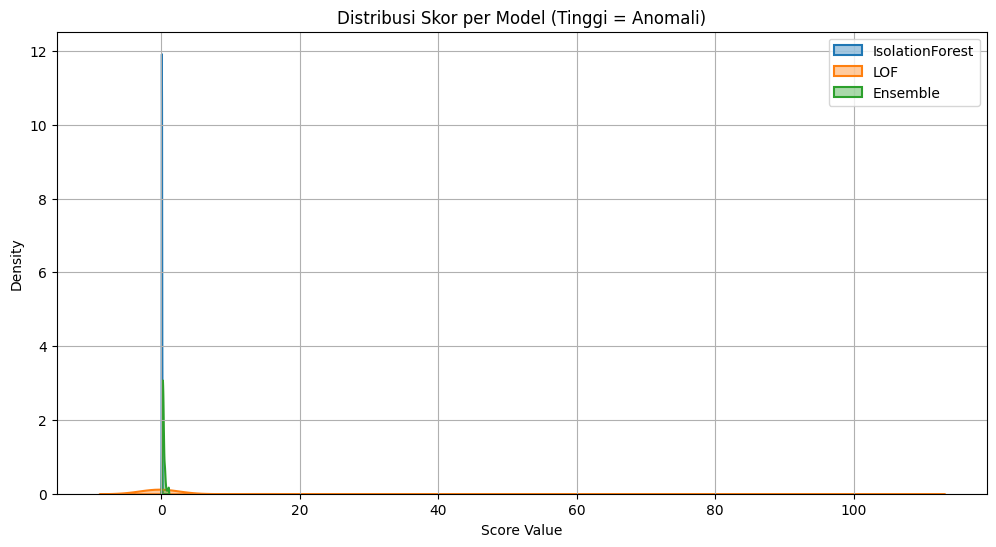

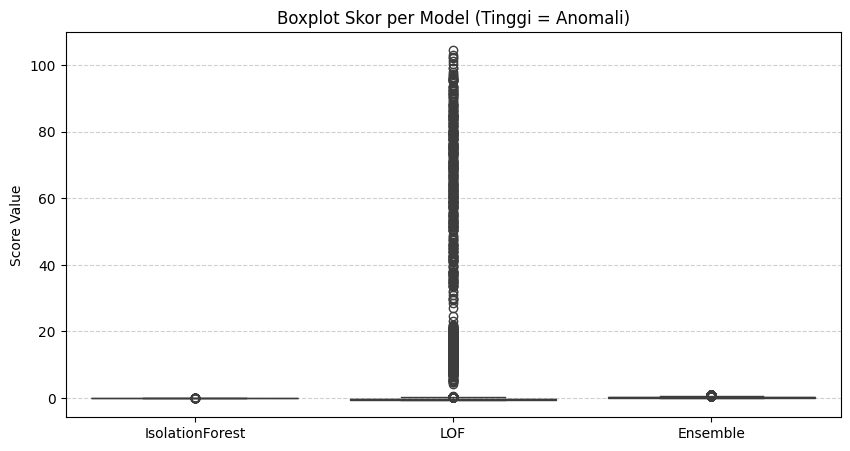

In [15]:
models = {
    # Gunakan skor yang sudah disesuaikan (tinggi = anomali)
    "IsolationForest": iso_adj_scores,
    "LOF": lof_adj_scores,
    "Ensemble": ens_adj_scores
}

stats = []
for name, s in models.items():
    s = np.array(s)
    stats.append({
        "Model": name,
        "Min": np.min(s),
        "Max": np.max(s),
        "Mean": np.mean(s),
        "Std": np.std(s)
    })

score_stats_df = pd.DataFrame(stats)
display(score_stats_df.style.format({
    "Min": "{:.4f}",
    "Max": "{:.4f}",
    "Mean": "{:.4f}",
    "Std": "{:.4f}"
}).hide(axis="index"))

# VISUALISASI: Distribusi Skor (Histogram + KDE)

plt.figure(figsize=(12, 6))
for name, s in models.items():
    sns.kdeplot(s, fill=True, label=name, linewidth=1.5, alpha=0.4)
plt.title("Distribusi Skor per Model (Tinggi = Anomali)")
plt.xlabel("Score Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# VISUALISASI: Boxplot Skor
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(models))
plt.title("Boxplot Skor per Model (Tinggi = Anomali)")
plt.ylabel("Score Value")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()